In [257]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import yfinance as yf
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.tsa.api import ExponentialSmoothing
from warnings import filterwarnings
filterwarnings('ignore')
plt.rcParams['figure.figsize']=16,10

## Stocks sectorwise

In [2]:
ss=pd.read_csv('stocks_sectorwise.csv',index_col=0)
ss.head()

,NIFTY 50,NIFTY AUTO,NIFTY BANK,NIFTY CONSUMER DURABLES,NIFTY ENERGY,NIFTY FINANCIAL SERVICES,NIFTY FMCG,NIFTY INDIA CONSUMPTION,NIFTY INFRASTRUCTURE,NIFTY IT,NIFTY METAL,NIFTY OIL & GAS,NIFTY PHARMA
0,M&M,M&M,FEDERALBNK,DIXON,TATAPOWER,PEL,MCDOWELL-N,JUBLFOOD,DLF,COFORGE,WELCORP,ATGL,GLENMARK
1,TITAN,TATAMOTORS,PNB,CROMPTON,RELIANCE,SRTRANSFIN,UBL,CROMPTON,IRCTC,MINDTREE,HINDCOPPER,RELIANCE,CIPLA
2,INFY,BALKRISIND,BANKBARODA,BATAINDIA,BPCL,CHOLAFIN,TATACONSUM,MCDOWELL-N,ADANIPORTS,LTI,ADANIENT,OIL,GRANULES
3,ADANIPORTS,SONACOMS,IDFCFIRSTB,TITAN,IOC,ICICIGI,DABUR,DMART,GODREJPROP,INFY,APLAPOLLO,MGL,DIVISLAB
4,LT,TVSMOTOR,ICICIBANK,HAVELLS,POWERGRID,SBILIFE,EMAMILTD,M&M,LT,MPHASIS,NATIONALUM,BPCL,ALKEM


## Function that scrapes stock data from screener

In [20]:
def screener(ind='KPITTECH'):
    url='https://www.screener.in/company/KPITTECH/consolidated/'
    l=url.split('/')    
    l[4]=ind
    url='/'.join(l)
    data = requests.get(url)
    soup = bs(data.content, 'html.parser')            
    
    col=[i.text for i in soup.find('section',attrs={'id':'quarters'}).find_all('th')]
    l=len(col)
    
    if l==1:
        url='https://www.screener.in/company/KPITTECH/'
        l=url.split('/')    
        l[4]=ind
        url='/'.join(l)
        data = requests.get(url)
        soup = bs(data.content, 'html.parser')            
        col=[]
        for i in soup.find_all('section',attrs={'id':'quarters'})[0].find_all('th'):
            col.append(i.text)
        l=len(col)
    
    val=np.array([i.text.strip() for i in soup.find('section',attrs={'id':'quarters'}).find_all('td')])
    
    if len(val)//l==12:
        val=val.reshape(12,l)
        qrdf=pd.DataFrame(val,columns=col).set_index('')
        qrdf.iloc[0]=qrdf.iloc[0].str.replace(',','').astype(int)
        qrdf.iloc[2]=qrdf.iloc[2].str.replace(',','').astype(int)
        qrdf.iloc[10]=qrdf.iloc[10].str.replace(',','').astype(float)
        qrdf=qrdf.iloc[[0,2,10]]
    else:
        val=val.reshape(14,l)
        qrdf=pd.DataFrame(val,columns=col).set_index('')
        qrdf.iloc[0]=qrdf.iloc[0].str.replace(',','').astype(int)
        qrdf.iloc[3]=qrdf.iloc[3].str.replace(',','').astype(int)
        qrdf.iloc[10]=qrdf.iloc[10].str.replace(',','').astype(float)
        qrdf=qrdf.iloc[[0,3,10]]

    
    col=[i.text for i in soup.find('section',attrs={'id':'profit-loss'}).find('div',class_='responsive-holder fill-card-width').find_all('th')]
    l=len(col)
    val=np.array([i.text.strip() for i in soup.find('section',attrs={'id':'profit-loss'}).find('div',class_='responsive-holder fill-card-width').find_all('td')]).reshape(12,l)
    pldf=pd.DataFrame(val,columns=col).set_index('')
    if val[0,0]=='Revenue':
        pldf.iloc[0]=pldf.iloc[0].str.replace(',','').astype(int)
        pldf.iloc[3]=pldf.iloc[3].str.replace(',','').astype(int)
        pldf.iloc[10]=pldf.iloc[10].str.replace(',','').astype(float)
        pldf=pldf.iloc[[0,3,10]]
    else:
        pldf.iloc[0]=pldf.iloc[0].str.replace(',','').astype(int)
        pldf.iloc[2]=pldf.iloc[2].str.replace(',','').astype(int)
        pldf.iloc[10]=pldf.iloc[10].str.replace(',','').astype(float)
        pldf=pldf.iloc[[0,2,10]]
    
    if pldf.columns[-1]=='TTM':
        pldf.drop('TTM',axis=1,inplace=True)
        
    l=[]
    for i in soup.find_all('table', class_='ranges-table')[0].find_all('td'):
        l.append(i.text[:-1])
    sg=[np.nan if i=='' else int(i) for i in l[1::2]]
    
    l=[]
    for i in soup.find_all('table', class_='ranges-table')[1].find_all('td'):
        l.append(i.text[:-1])
    pg=[np.nan if i=='' else int(i) for i in l[1::2]]
    
    col=[i.text for i in soup.find('section',attrs={'id':'balance-sheet'}).find_all('th')]
    l=len(col)
    val=np.array([i.text.strip() for i in soup.find('section',attrs={'id':'balance-sheet'}).find_all('td')]).reshape(10,l)
    bsdf=pd.DataFrame(val,columns=col).set_index('').replace({'':np.nan})
    pldf.loc['Equity']= bsdf.iloc[[0,1]].replace({',':''},regex=True).astype(float).sum().replace({0:np.nan}).to_list()
    pldf.loc['Borrowings']=bsdf.iloc[2].replace({',':''},regex=True).astype(float).to_list()
    return qrdf,pldf,sg,pg

* qrdf - DataFrame with rows 'Sales', 'Operating Profit' and 'EPS in Rs' from Quarterly Results table
* pldf - DataFrame with rows 'Sales', 'Operating Profit' and 'EPS in Rs' from Profit & Loss table and 'Equity' ('Share Capital'+'Reserves') and 'Borrowings' from Balance Sheet table
* sg - list of compounded sales rowth ['10 years','5 years','3 years','TTM'] 
* pg - list of compounded profit growth ['10 years','5 years','3 years','TTM']

## Parsing correlation of each independent variable with the price of stock

In [22]:
qcdf=pd.DataFrame(columns=['sales_price','profit_price','eps_price','nifty_price'])
acdf=pd.DataFrame(columns=['sales_price','profit_price','eps_price','equity_price','borrowings_price','nifty_price'])
sgdf=pd.DataFrame(columns=['10 Years','5 Years','3 Years','TTM'])
pgdf=pd.DataFrame(columns=['10 Years','5 Years','3 Years','TTM'])

for ind in ss.iloc[:,0]:
    qdf,pdf,sg,pg=screener(ind)
    n=yf.Ticker('^NSEI').history(interval='1mo',start=pd.to_datetime(pdf.columns[0]),end=pd.to_datetime(pdf.columns[-1]))#.resample('a-mar').agg('last').Close.to_list()
    p=yf.Ticker(ind+'.NS').history(interval='1mo',start=pd.to_datetime(pdf.columns[0]),end=pd.to_datetime(pdf.columns[-1]))#.resample('a-mar').agg('last').Close.to_list()
    pdf.loc['Nifty']=n.loc[pd.to_datetime(pdf.columns)].Close.to_list()
    if p.index[0]!=pd.to_datetime(pdf.columns[0]):
        col=pd.to_datetime(pdf.columns)&p.index
        pdf.loc['Price']=[np.nan]*(len(pd.to_datetime(pdf.columns))-len(col))+p.loc[col].Close.to_list()
    else:
        pdf.loc['Price']=p.loc[pd.to_datetime(pdf.columns)].Close.to_list()
    acdf.loc[ind]=pdf.T.astype(float).corr().Price[:-1].to_list()
    
    n=yf.Ticker('^NSEI').history(interval='1mo',start=pd.to_datetime(qdf.columns[0]),end=pd.to_datetime(qdf.columns[-1]))#.resample('q').agg('last').Close.to_list()
    p=yf.Ticker(ind+'.NS').history(interval='1mo',start=pd.to_datetime(qdf.columns[0]),end=pd.to_datetime(qdf.columns[-1]))#.resample('q').agg('last').Close.to_list()
    qdf.loc['Nifty']=n.loc[pd.to_datetime(qdf.columns)].Close.to_list()
    qdf.loc['Price']=p.loc[pd.to_datetime(qdf.columns)].Close.to_list()
    qcdf.loc[ind]=qdf.T.astype(float).corr().Price[:-1].to_list()
    sgdf.loc[ind]=sg
    pgdf.loc[ind]=pg
    print(ind,end=',')

M&M,TITAN,INFY,ADANIPORTS,LT,HCLTECH,TECHM,TCS,RELIANCE,TATACONSUM,GRASIM,UPL,TATAMOTORS,ULTRACEMCO,COALINDIA,

C:\Users\RAKESH~1\AppData\Local\Temp/ipykernel_27920/2099421219.py:12: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  col=pd.to_datetime(pdf.columns)&p.index


SBILIFE,BPCL,SHREECEM,CIPLA,HEROMOTOCO,BAJFINANCE,WIPRO,BHARTIARTL,HINDALCO,DIVISLAB,HDFC,POWERGRID,HDFCLIFE,BAJAJFINSV,ICICIBANK,SBIN,INDUSINDBK,EICHERMOT,MARUTI,APOLLOHOSP,AXISBANK,NESTLEIND,HINDUNILVR,BRITANNIA,BAJAJ-AUTO,HDFCBANK,ASIANPAINT,NTPC,TATASTEEL,ONGC,ITC,DRREDDY,SUNPHARMA,JSWSTEEL,KOTAKBANK,

In [24]:
pd.concat([acdf,qcdf],axis=1).head()

,sales_price,profit_price,eps_price,equity_price,borrowings_price,nifty_price,sales_price,profit_price,eps_price,nifty_price
M&M,0.677162,0.778419,0.532296,0.700635,0.568005,0.844770,0.561405,0.551621,0.823865,0.932315
TITAN,0.954791,0.915312,0.893976,0.935261,0.955977,0.960938,0.743571,0.650287,0.655181,0.947061
INFY,0.878548,0.913689,0.876152,0.689912,0.834141,0.948424,0.976371,0.936815,0.943629,0.951372
ADANIPORTS,0.855986,0.882026,0.845017,0.899099,0.881511,0.984429,0.780834,0.557407,0.352918,0.964652
LT,0.803791,0.786196,0.691364,0.851750,0.728493,0.970191,0.340312,0.236529,-0.209659,0.895773


In [45]:
pd.concat([sgdf,pgdf],axis=1).head()

,10 Years,5 Years,3 Years,TTM,10 Years,5 Years,3 Years,TTM
M&M,4,1,-5,21,8,13,7,226
TITAN,13,17,13,33,14,23,17,130
INFY,14,12,14,21,10,9,13,14
ADANIPORTS,19,14,13,27,16,6,8,2
LT,9,7,5,15,7,8,0,-38


## Stock recent peak date and trough date after recent peak

In [40]:
spt=pd.DataFrame(columns=['rec_peak_date','pp_low_date'])
for i in ss.iloc[:,0]:
    df=yf.Ticker(i+'.NS').history(period='2y',interval='1wk')
    if len(df)>0:
        tdf=df.loc[df[df.High==df.High.max()].index[0]:]
        spt.loc[i]=[df[df.High==df.High.max()].index[0],tdf[tdf.Low==tdf.Low.min()].index[0]]
        print(i,end=',')

M&M,TITAN,INFY,ADANIPORTS,LT,HCLTECH,TECHM,TCS,RELIANCE,TATACONSUM,GRASIM,UPL,TATAMOTORS,ULTRACEMCO,COALINDIA,SBILIFE,BPCL,SHREECEM,CIPLA,HEROMOTOCO,BAJFINANCE,WIPRO,BHARTIARTL,HINDALCO,DIVISLAB,HDFC,POWERGRID,HDFCLIFE,BAJAJFINSV,ICICIBANK,SBIN,INDUSINDBK,EICHERMOT,MARUTI,APOLLOHOSP,AXISBANK,NESTLEIND,HINDUNILVR,BRITANNIA,BAJAJ-AUTO,HDFCBANK,ASIANPAINT,NTPC,TATASTEEL,ONGC,ITC,DRREDDY,SUNPHARMA,JSWSTEEL,KOTAKBANK,

In [41]:
spt.head()

,rec_peak_date,pp_low_date
M&M,2022-05-30,2022-05-30
TITAN,2022-03-21,2022-06-20
INFY,2022-01-17,2022-06-13
ADANIPORTS,2022-04-25,2022-06-20
LT,2022-01-17,2022-06-20


## Covid low date and recent peak date

In [117]:
ctp=pd.DataFrame(columns=['covid_low_date','recent_peak_date'])
for i in ss.iloc[:,0]:
    df=yf.Ticker(i+'.NS').history(interval='1wk',start='2020-01-01')
    if len(df)>0:
        tdf=df.loc[df[df.Low==df.Low.min()].index[0]:]
        ctp.loc[i]=[tdf.head(1).index[0],tdf[tdf.High==tdf.High.max()].index[0]]
        print(i,end=',')

M&M,TITAN,INFY,ADANIPORTS,LT,HCLTECH,TECHM,TCS,RELIANCE,TATACONSUM,GRASIM,UPL,TATAMOTORS,ULTRACEMCO,COALINDIA,SBILIFE,BPCL,SHREECEM,CIPLA,HEROMOTOCO,BAJFINANCE,WIPRO,BHARTIARTL,HINDALCO,DIVISLAB,HDFC,POWERGRID,HDFCLIFE,BAJAJFINSV,ICICIBANK,SBIN,INDUSINDBK,EICHERMOT,MARUTI,APOLLOHOSP,AXISBANK,NESTLEIND,HINDUNILVR,BRITANNIA,BAJAJ-AUTO,HDFCBANK,ASIANPAINT,NTPC,TATASTEEL,ONGC,ITC,DRREDDY,SUNPHARMA,JSWSTEEL,KOTAKBANK,

In [119]:
ctp.head()

,covid_low_date,recent_peak_date
M&M,2020-03-23,2022-05-30
TITAN,2020-03-23,2022-03-21
INFY,2020-03-16,2022-01-17
ADANIPORTS,2020-03-23,2022-04-25
LT,2020-03-23,2022-01-17


## Relative date diff to Nifty

In [42]:
n50=yf.Ticker('^NSEI').history(period='2y',interval='1wk')
tdf=n50.loc[n50[n50.High==n50.High.max()].index[0]:]
spt['peaked_after']=spt.rec_peak_date-n50[n50.High==n50.High.max()].index[0]
spt['troughed_before']=tdf[tdf.Low==tdf.Low.min()].index[0]-spt.pp_low_date
spt.iloc[:,[2,3]]=spt.iloc[:,[2,3]].astype(str)
spt.peaked_after=spt.peaked_after.apply(lambda x:x.split()[0]).astype(int)
spt.troughed_before=spt.troughed_before.apply(lambda x:x.split()[0]).astype(int)
spt.drop(spt.columns[:2],axis=1,inplace=True)

In [44]:
spt.head()

,peaked_after,troughed_before
M&M,224,14
TITAN,154,-7
INFY,91,0
ADANIPORTS,189,-7
LT,91,-7


In [131]:
n50=yf.Ticker('^NSEI').history(interval='1wk',start='2020-01-01')
tdf=n50.loc[n50[n50.Low==n50.Low.min()].index[0]:]
ctp['troughed_before']=tdf.head(1).index[0]-ctp.covid_low_date
ctp['peaked_after']=ctp.recent_peak_date-tdf[tdf.High==tdf.High.max()].index[0]
ctp.iloc[:,[2,3]]=ctp.iloc[:,[2,3]].astype(str)
ctp.peaked_after=ctp.peaked_after.apply(lambda x:x.split()[0]).astype(int)
ctp.troughed_before=ctp.troughed_before.apply(lambda x:x.split()[0]).astype(int)
ctp.drop(ctp.columns[:2],axis=1,inplace=True)

In [135]:
ctp.head()

,troughed_before,peaked_after
M&M,0,224
TITAN,0,154
INFY,7,91
ADANIPORTS,0,189
LT,0,91


## Sum of change in percentage of stock's price relative to Nifty over different time period

In [33]:
def green_red(ind,p):
    df=yf.Ticker(ind+'.NS').history(period=p,interval='1wk')
    return (((df.Close-df.Open)/df.Open)*100)
prd=['5y','2y','1y','6mo','3mo']
rpdf=pd.DataFrame(index=ss.iloc[:,0].to_list())
for p in prd:
    n50=yf.Ticker('^NSEI').history(period=p,interval='1wk')
    df=pd.DataFrame(columns=n50.index)
    df.loc['Nifty50']=(((n50.Close-n50.Open)/n50.Open)*100)
    for i in ss.iloc[:,0].to_list():
        df.loc[i]=green_red(i,p)
    rpdf[p]=((df.iloc[1:]-df.iloc[0])).T.sum().to_list()
    print(p,end=',')

5y,2y,1y,6mo,3mo,

In [95]:
rpdf.head()

,5y,2y,1y,6mo,3mo
M&M,27.892134,39.093555,21.761224,24.504046,31.843336
TITAN,90.914912,39.992681,14.304090,-3.296844,-19.176796
INFY,100.914588,48.925458,8.500252,-7.170690,-7.000209
ADANIPORTS,46.922369,39.078382,-7.548039,-1.205404,-0.865504
LT,2.341819,18.936095,5.818529,-10.900382,-8.379643


## Exploratory data analysis

<AxesSubplot:xlabel='percent', ylabel='ticker'>

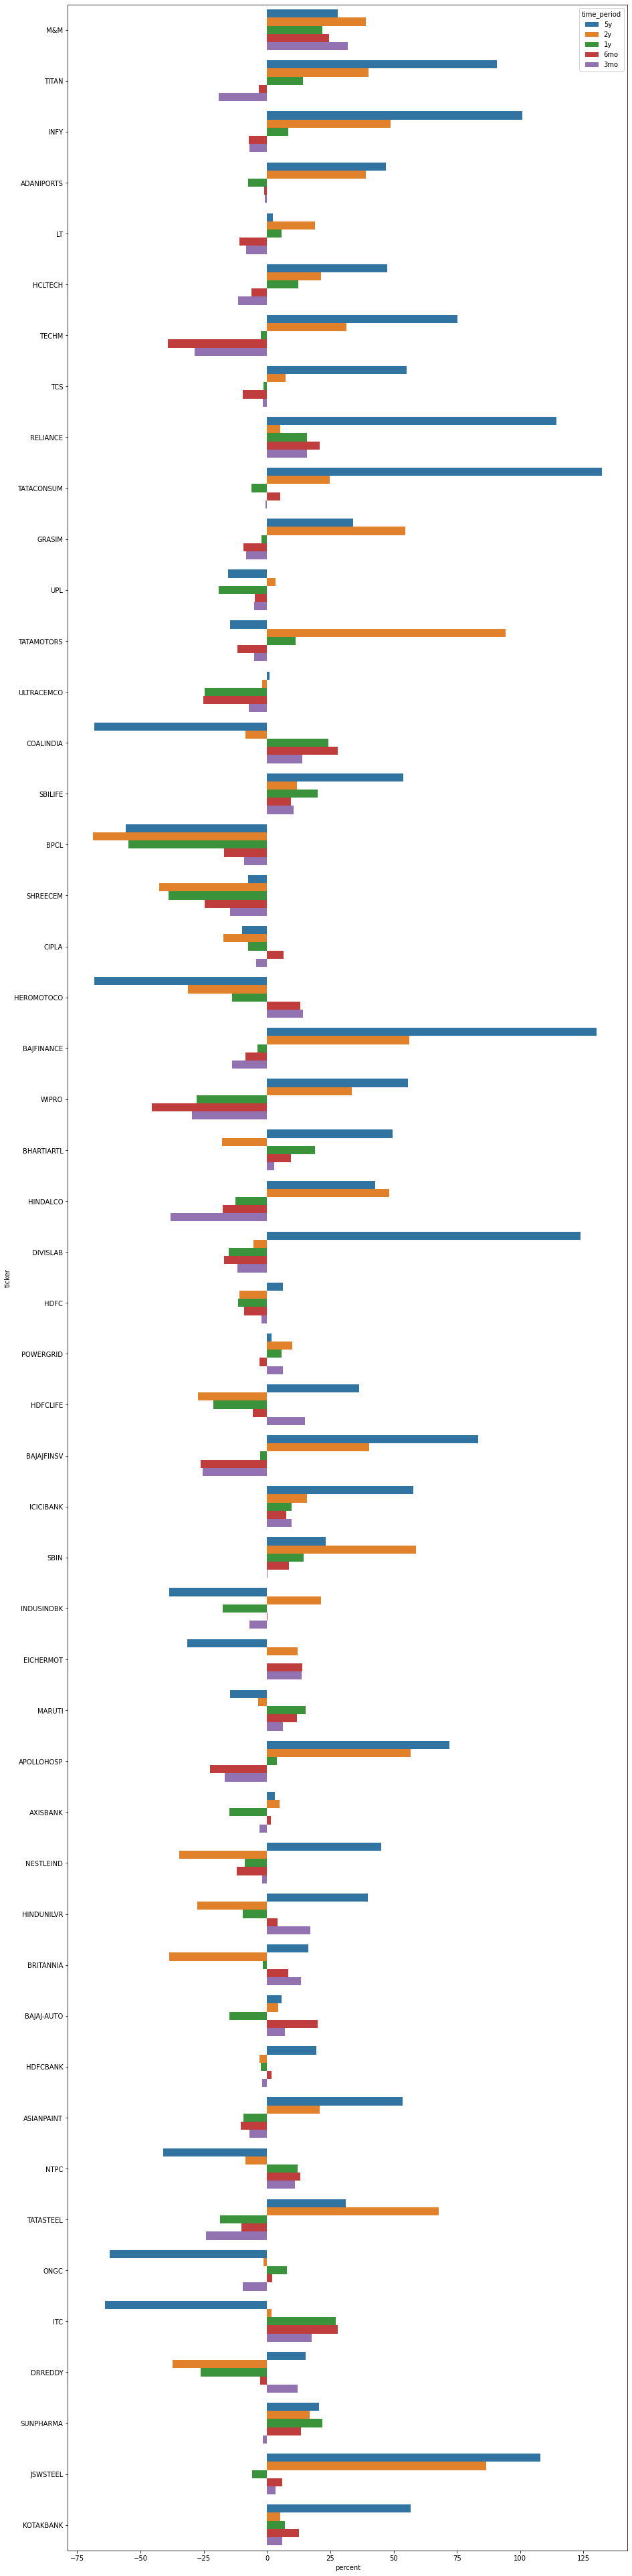

In [93]:
plt.figure(figsize=[15,70])
df=pd.DataFrame(columns=['ticker','percent','time_period'])
for i in rpdf.columns:
    t=rpdf.reset_index().loc[:,['index',i]].rename({'index':'ticker',i:'percent'},axis=1)
    t['time_period']=i
    df=pd.concat([df,t])
sb.barplot(data=df,y='ticker',x='percent',hue='time_period')

## Stocks that outperform the nifty are abbreviated as "movers" and stocks that underperform as "shakers".

### Absolute movers

In [234]:
mvr=rpdf[(rpdf>5).all(axis=1)].index.to_list()
rpdf[(rpdf>5).all(axis=1)]

,5y,2y,1y,6mo,3mo
M&M,27.892134,39.093555,21.761224,24.504046,31.843336
RELIANCE,114.255551,5.130432,15.862711,20.739735,15.867577
SBILIFE,53.874476,11.888935,20.027122,9.440068,10.439213
ICICIBANK,57.784128,15.732406,9.814508,7.529507,9.667370
KOTAKBANK,56.819162,5.251343,7.119448,12.500243,5.901077


### Absolute shakers

In [233]:
skr=rpdf[(rpdf<0).all(axis=1)].index.to_list()
rpdf[(rpdf<0).all(axis=1)]

,5y,2y,1y,6mo,3mo
BPCL,-55.699894,-68.661281,-54.661700,-16.898359,-9.166030
SHREECEM,-7.349975,-42.614813,-38.876283,-24.723213,-14.591954


### shakers turned movers

In [104]:
rpdf[np.where(rpdf['5y']<rpdf['2y'],np.where(rpdf['2y']<rpdf['1y'],np.where(rpdf['1y']<rpdf['6mo'],np.where(rpdf['6mo']<rpdf['3mo'],True,False),False),False),False)]

,5y,2y,1y,6mo,3mo
HEROMOTOCO,-68.223404,-31.333681,-13.70895,13.240407,14.282032


### movers turned shakers

In [105]:
rpdf[np.where(rpdf['5y']>rpdf['2y'],np.where(rpdf['2y']>rpdf['1y'],np.where(rpdf['1y']>rpdf['6mo'],np.where(rpdf['6mo']>rpdf['3mo'],True,False),False),False),False)]

,5y,2y,1y,6mo,3mo
TITAN,90.914912,39.992681,14.304090,-3.296844,-19.176796
HCLTECH,47.430374,21.365222,12.439418,-6.031484,-11.513814
BAJFINANCE,130.294871,56.112357,-3.840994,-8.456443,-13.693388


## Stocks that peak or trough before nifty are abbreviated as "leaders" and vice versa, as "laggers."

### laggers turned leaders

In [147]:
ctp[(ctp<0).all(axis=1)]

,troughed_before,peaked_after
SHREECEM,-7,-196
EICHERMOT,-14,-273
TATASTEEL,-7,-63


* short bull run

In [106]:
spt[(spt>0).all(axis=1)]

,peaked_after,troughed_before
M&M,224,14
RELIANCE,189,35
TATAMOTORS,28,35
COALINDIA,182,35
SBILIFE,91,98
HDFC,28,98
ICICIBANK,7,98
SBIN,112,98
MARUTI,112,98
APOLLOHOSP,35,21


* short bear run

### leaders turned laggers

In [143]:
ctp[(ctp>0).all(axis=1)]

,troughed_before,peaked_after
INFY,7,91
TCS,14,91
SBILIFE,7,91
CIPLA,14,147
BHARTIARTL,7,35
POWERGRID,7,203
ASIANPAINT,7,84
ONGC,14,140
ITC,14,210
KOTAKBANK,7,7


* long bull run

In [107]:
spt[(spt<0).all(axis=1)]

,peaked_after,troughed_before
UPL,-133,-9
SHREECEM,-196,-7


* long bear run

### leaders

In [141]:
ctp[(ctp.peaked_after<0)&(ctp.troughed_before>0)]

,troughed_before,peaked_after
HCLTECH,7,-28
WIPRO,7,-7
HINDUNILVR,7,-28
DRREDDY,7,-105


In [108]:
spt[(spt.peaked_after<0)&(spt.troughed_before>0)]

,peaked_after,troughed_before
TATACONSUM,-42,98
HEROMOTOCO,-245,98
HDFCLIFE,-49,98
EICHERMOT,-273,98
NESTLEIND,-35,28
HINDUNILVR,-28,98
BRITANNIA,-35,98
BAJAJ-AUTO,-259,175
DRREDDY,-105,105


### laggers

In [142]:
ctp[(ctp.peaked_after>0)&(ctp.troughed_before<0)]

,troughed_before,peaked_after
COALINDIA,-203,182
SBIN,-56,112
MARUTI,-7,112
APOLLOHOSP,-7,35
SUNPHARMA,-7,189
JSWSTEEL,-7,182


In [109]:
spt[(spt.peaked_after>0)&(spt.troughed_before<0)]

,peaked_after,troughed_before
TITAN,154,-7
ADANIPORTS,189,-7
LT,91,-7
CIPLA,147,-7
BHARTIARTL,35,-7
HINDALCO,161,-7
POWERGRID,203,-7
INDUSINDBK,7,-9
AXISBANK,7,-9
NTPC,182,-7


In [223]:
t=pd.concat([ctp.drop('peaked_after',axis=1),spt],axis=1)
t.columns=['troughed_before(cov)','peaked_after(rec)','troughed_before(rec)']
t[(t>=0).all(axis=1)]

,troughed_before(cov),peaked_after(rec),troughed_before(rec)
M&M,0,224,14
INFY,7,91,0
TECHM,0,70,0
TCS,14,91,0
RELIANCE,0,189,35
GRASIM,0,91,0
TATAMOTORS,0,28,35
ULTRACEMCO,0,21,0
SBILIFE,7,91,98
DIVISLAB,14,0,21


In [224]:
t[(t>0).all(axis=1)]

,troughed_before(cov),peaked_after(rec),troughed_before(rec)
SBILIFE,7,91,98
ITC,14,210,28


* Stocks that had a long bull run and a short bear run when compared to the nifty

## A comparison of sales and profit growth rates over time

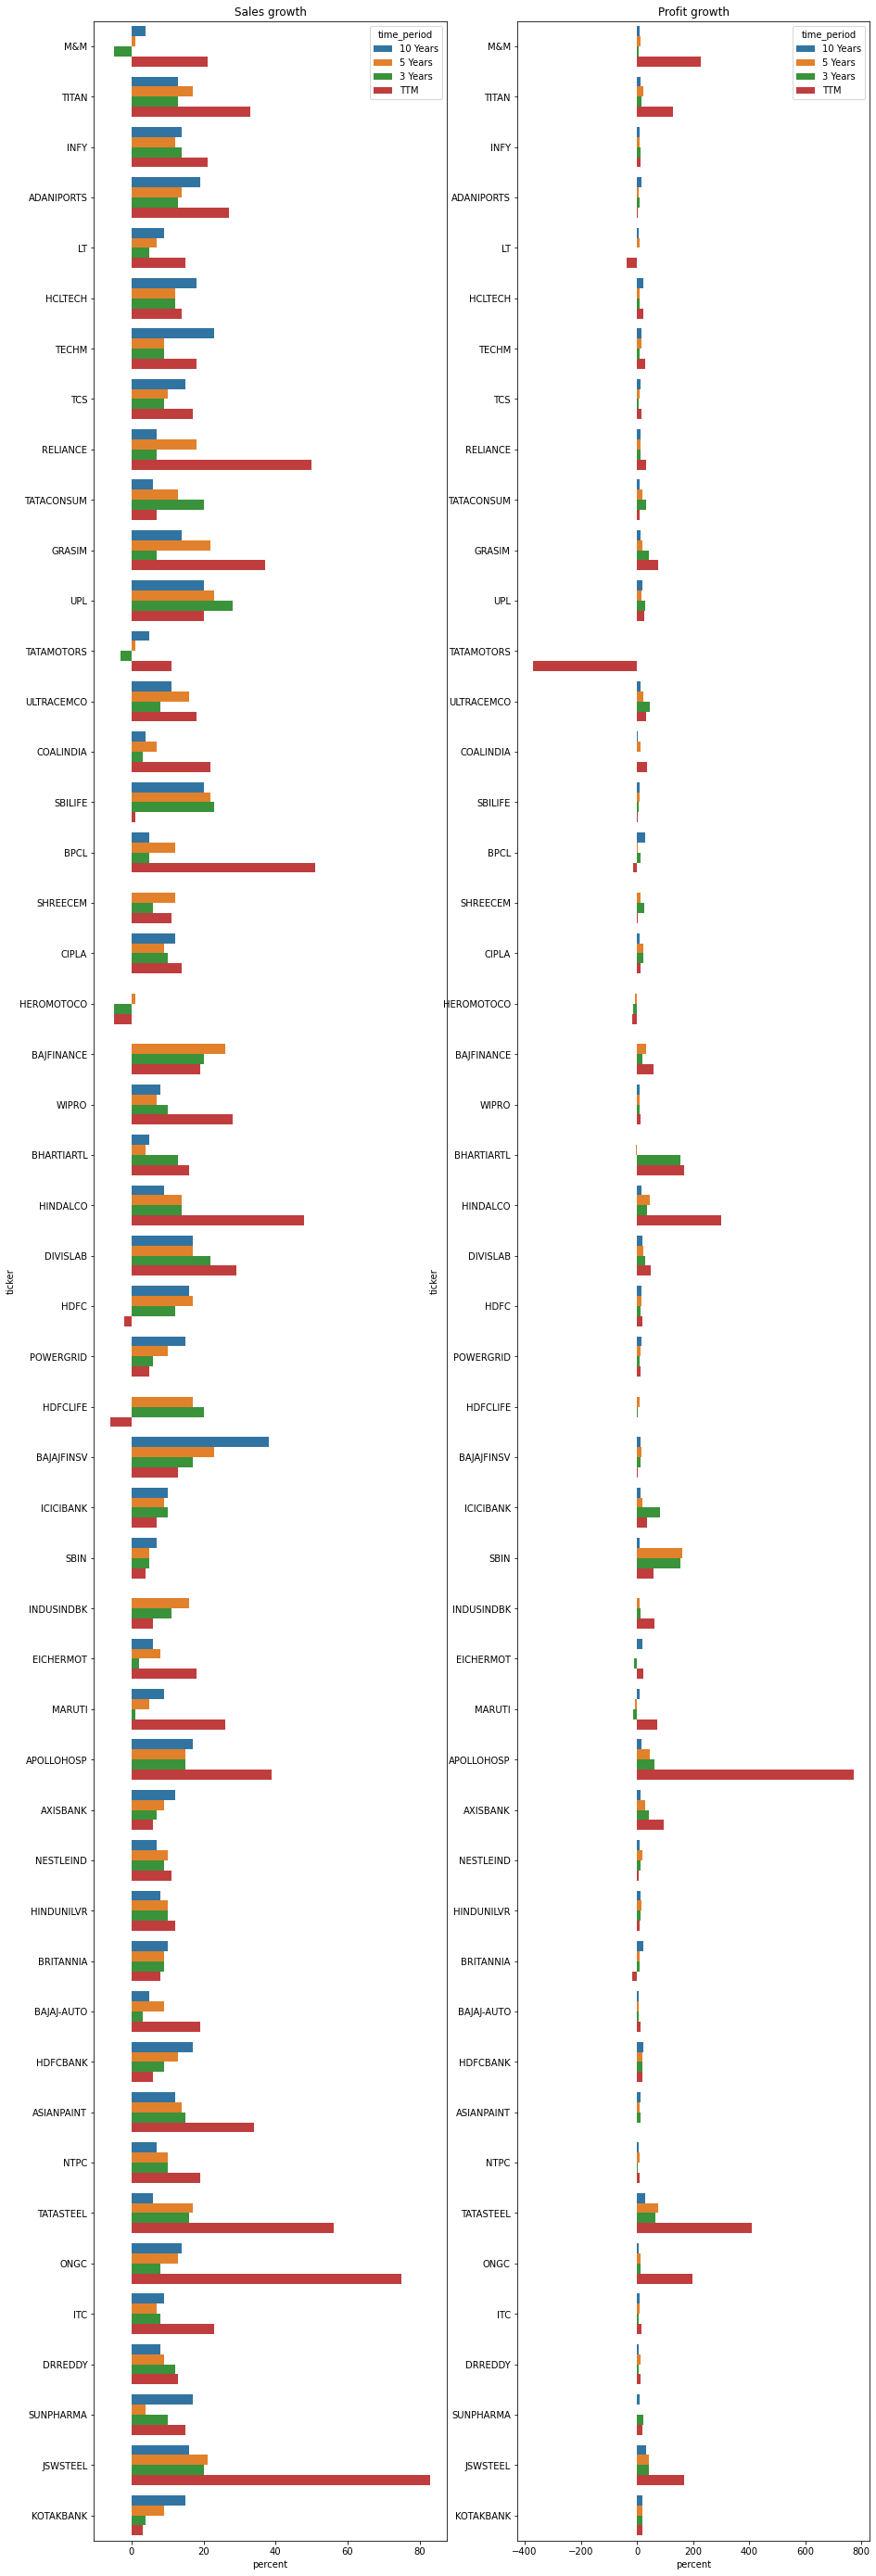

In [170]:
plt.figure(figsize=[15,50])
dfs=pd.DataFrame(columns=['ticker','percent','time_period'])
for i in sgdf.columns:
    t=sgdf.reset_index().loc[:,['index',i]].rename({'index':'ticker',i:'percent'},axis=1)
    t['time_period']=i
    dfs=pd.concat([dfs,t])
plt.subplot(1,2,1)
sb.barplot(data=dfs,y='ticker',x='percent',hue='time_period')
plt.title('Sales growth')
dfp=pd.DataFrame(columns=['ticker','percent','time_period'])
for i in pgdf.columns:
    t=pgdf.reset_index().loc[:,['index',i]].rename({'index':'ticker',i:'percent'},axis=1)
    t['time_period']=i
    dfp=pd.concat([dfp,t])
plt.subplot(1,2,2)
sb.barplot(data=dfp,y='ticker',x='percent',hue='time_period')
plt.title('Profit growth')
plt.show()

### Stocks with compounded sales growth of over 10% per year.

In [155]:
sgdf[(sgdf>10).all(axis=1)]

,10 Years,5 Years,3 Years,TTM
TITAN,13,17,13,33
INFY,14,12,14,21
ADANIPORTS,19,14,13,27
HCLTECH,18,12,12,14
UPL,20,23,28,20
DIVISLAB,17,17,22,29
BAJAJFINSV,38,23,17,13
APOLLOHOSP,17,15,15,39
ASIANPAINT,12,14,15,34
JSWSTEEL,16,21,20,83


### Profit growth of stocks with compounded sales growth of over 10% per year.

In [172]:
pgdf.loc[sgdf[(sgdf>10).all(axis=1)].index]

,10 Years,5 Years,3 Years,TTM
TITAN,14,23,17,130
INFY,10,9,13,14
ADANIPORTS,16,6,8,2
HCLTECH,23,10,11,23
UPL,21,17,29,27
DIVISLAB,19,23,30,49
BAJAJFINSV,13,15,12,2
APOLLOHOSP,15,45,62,773
ASIANPAINT,12,10,13,-1
JSWSTEEL,34,43,41,167


### Stocks with compounded profit growth of over 10% per year.

In [157]:
pgdf[(pgdf>10).all(axis=1)]

,10 Years,5 Years,3 Years,TTM
TITAN,14,23,17,130
RELIANCE,12,14,14,33
TATACONSUM,11,20,33,11
GRASIM,12,19,44,74
UPL,21,17,29,27
ULTRACEMCO,13,22,45,33
HINDALCO,15,47,37,300
DIVISLAB,19,23,30,49
HDFC,15,15,12,21
ICICIBANK,13,20,81,37


### Sales growth of stocks with compounded profit growth of over 10% per year.

In [225]:
sgdf.loc[pgdf[(pgdf>10).all(axis=1)].index]

,10 Years,5 Years,3 Years,TTM
TITAN,13,17,13,33
RELIANCE,7,18,7,50
TATACONSUM,6,13,20,7
GRASIM,14,22,7,37
UPL,20,23,28,20
ULTRACEMCO,11,16,8,18
HINDALCO,9,14,14,48
DIVISLAB,17,17,22,29
HDFC,16,17,12,-2
ICICIBANK,10,9,10,7


## Validation

In [239]:
t.loc[mvr]

,troughed_before(cov),peaked_after(rec),troughed_before(rec)
M&M,0,224,14
RELIANCE,0,189,35
SBILIFE,7,91,98
ICICIBANK,0,7,98
KOTAKBANK,7,7,0


* mover are bought early and sold late

In [240]:
t.loc[skr]

,troughed_before(cov),peaked_after(rec),troughed_before(rec)
BPCL,0,0,-7
SHREECEM,-7,-196,-7


* shakers are bought late and sold early

In [241]:
sgdf.loc[mvr]

,10 Years,5 Years,3 Years,TTM
M&M,4,1,-5,21
RELIANCE,7,18,7,50
SBILIFE,20,22,23,1
ICICIBANK,10,9,10,7
KOTAKBANK,15,9,4,3


In [242]:
pgdf.loc[mvr]

,10 Years,5 Years,3 Years,TTM
M&M,8,13,7,226
RELIANCE,12,14,14,33
SBILIFE,11,10,6,3
ICICIBANK,13,20,81,37
KOTAKBANK,21,20,19,21


* Although 3 years sales growth of M&M is negative, its profit is positive. Its TTM profit growth is more than 200%

In [245]:
acm=pd.DataFrame(columns=['metrics','corr'])
df=acdf.drop('nifty_price',axis=1)
for i in df.index:
    acm.loc[i]=[df.loc[i][df.loc[i]==df.loc[i].max()].index[0],df.loc[i].max()]
acm.head()

,metrics,corr
M&M,profit_price,0.778419
TITAN,borrowings_price,0.955977
INFY,profit_price,0.913689
ADANIPORTS,equity_price,0.899099
LT,equity_price,0.851750


In [246]:
qcm=pd.DataFrame(columns=['metrics','corr'])
df=qcdf.drop('nifty_price',axis=1)
for i in df.index:
    qcm.loc[i]=[df.loc[i][df.loc[i]==df.loc[i].max()].index[0],df.loc[i].max()]
qcm.head()

,metrics,corr
M&M,eps_price,0.823865
TITAN,sales_price,0.743571
INFY,sales_price,0.976371
ADANIPORTS,sales_price,0.780834
LT,sales_price,0.340312


In [247]:
acm.loc[mvr]

,metrics,corr
M&M,profit_price,0.778419
RELIANCE,equity_price,0.983611
SBILIFE,equity_price,0.882913
ICICIBANK,equity_price,0.913306
KOTAKBANK,equity_price,0.988282


In [248]:
qcm.loc[mvr]

,metrics,corr
M&M,eps_price,0.823865
RELIANCE,eps_price,0.760059
SBILIFE,sales_price,0.712027
ICICIBANK,eps_price,0.806487
KOTAKBANK,eps_price,0.425642


## Forecast the stock's corresponding metric. If the actual metric is surpassed by the forecasted metric, accumulate the stocks, else dissipate the stocks.

In [249]:
qdf,pdf,sg,pg=screener('M&M')

In [251]:
qdf.iloc[2]

Jun 2019     7.35
Sep 2019      2.8
Dec 2019     1.61
Mar 2020   -10.74
Jun 2020    -0.79
Sep 2020     1.09
Dec 2020     5.67
Mar 2021     0.64
Jun 2021     3.41
Sep 2021    15.51
Dec 2021    15.99
Mar 2022     18.0
Name: EPS in Rs, dtype: object

In [258]:
tsf=ExponentialSmoothing(qdf.iloc[2].astype(float),trend='add',seasonal='add').fit()
tsf.forecast(1)

2022-06-01    26.763276
Freq: QS-DEC, dtype: float64